# MLP

Use one neuron.

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-10-20 11:31:13.169650
Python 3.10.0
sklearn 1.1.2


In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LayerNormalization

dt='float32'
tf.keras.backend.set_floatx(dt)

ALPHABET_SIZE=4
K=4
VOCABULARY_SIZE = ALPHABET_SIZE**K 
from TrainValidSplit2 import Splitter2
EPOCHS=10
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

In [3]:
ATLAS_DIR = '/Users/jasonmiller/WVU/Localization/LncAtlas/'
RCI_FILE = 'CNRCI_coding_train_genes.csv'
GENCODE_DIR = '/Users/jasonmiller/WVU/Localization/GenCode/'
COUNTS_FILE='CNRCI_coding_train_counts.K4.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    act='relu'
    dense1_layer = keras.layers.Dense(4, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(4, activation=act,dtype=dt)
    dense3_layer = keras.layers.Dense(2, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation='sigmoid',dtype=dt)

    mlp = keras.models.Sequential()
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    mlp.add(dense3_layer)
    mlp.add(output_layer)

    # Here is the joke model insted
    mlp = keras.models.Sequential()
    one_layer = keras.layers.Dense(1, activation='sigmoid',dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    mlp.add(one_layer)
    
    
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-10-20 11:31:26.138151
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________
None


2022-10-20 11:31:26.151408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train and validate

In [7]:
# Data setup
print(datetime.now())
Kmer_counts_filepath = GENCODE_DIR+COUNTS_FILE
atlas_filepath = ATLAS_DIR+RCI_FILE

splitter=Splitter2()
splitter.load_counts_universe(Kmer_counts_filepath)
universe = splitter.get_gene_universe(atlas_filepath, CELL_LINE_NUMBER)
print(datetime.now())

2022-10-20 11:31:26.344351
Loaded values for cell line 0
Selected 10354 values out of 13930
2022-10-20 11:31:29.544676


Thresholds (-1.266972910885237, 1.1401767974371442)
Train set ones/size 5469 / 12019
Valid set ones/size 1418 / 2795
BUILD MODEL
COMPILE...
...COMPILED
FIT
Epoch 1/10
376/376 [==============================] - 1s 3ms/step - loss: 0.8420 - accuracy: 0.7659 - val_loss: 0.6654 - val_accuracy: 0.7463
Epoch 2/10
376/376 [==============================] - 1s 2ms/step - loss: 0.5856 - accuracy: 0.7938 - val_loss: 0.5584 - val_accuracy: 0.7814
Epoch 3/10
376/376 [==============================] - 1s 2ms/step - loss: 0.4832 - accuracy: 0.8127 - val_loss: 0.5183 - val_accuracy: 0.7728
Epoch 4/10
376/376 [==============================] - 1s 2ms/step - loss: 0.4443 - accuracy: 0.8272 - val_loss: 0.4226 - val_accuracy: 0.8297
Epoch 5/10
376/376 [==============================] - 1s 2ms/step - loss: 0.4128 - accuracy: 0.8370 - val_loss: 0.4607 - val_accuracy: 0.8236
Epoch 6/10
376/376 [==============================] - 1s 3ms/step - loss: 0.3936 - accuracy: 0.8448 - val_loss: 0.4182 - val_accuracy:

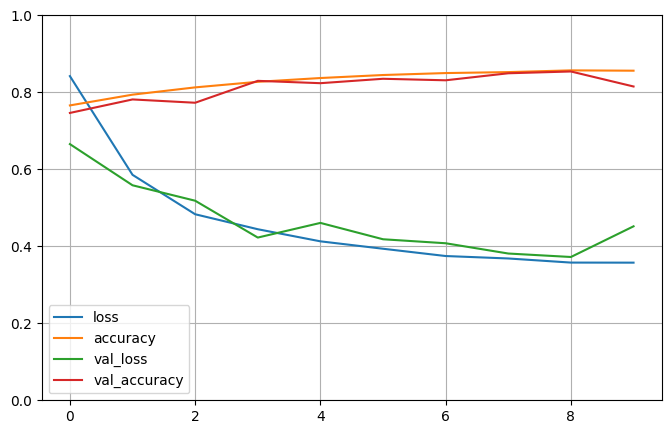

accuracy: 81.50%


In [8]:
data_partitions = splitter.get_train_valid_partitions(universe)
one_partition =data_partitions[0]
train_genes,valid_genes = one_partition[0],one_partition[1]
thresholds = splitter.choose_thresholds(train_genes,'one_z')
X_train,y_train = splitter.get_X_y(train_genes, thresholds)
X_valid,y_valid = splitter.get_X_y(valid_genes, thresholds)

print('Thresholds',thresholds)
print('Train set ones/size',
      np.count_nonzero(y_train),'/',len(y_train))
print('Valid set ones/size',
      np.count_nonzero(y_valid),'/',len(y_valid))

print("BUILD MODEL")
model=build_model()

print("FIT")
history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
        epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
        validation_data=(X_valid,y_valid) )

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

scores = model.evaluate(X_valid, y_valid, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


In [25]:
# https://www.tensorflow.org/guide/variable
w=model.trainable_weights[0].numpy()
b=model.trainable_weights[1].numpy()
print('bias',b)
print(len(w),'weights min=',min(w),'max=',max(w))

bias [1.1574006]
256 weights min= [-0.1667962] max= [0.18050809]


In [36]:
from KmerCounter import KmerCounter
counter = KmerCounter(4)
show_kmer = 'AAAA'
pairs = []
for i in range(len(w)):
    val = float(w[i])
    pair = (show_kmer,val,i)
    pairs.append(pair)
    show_kmer = counter.next_kmer(show_kmer)
    print(pair)

('AAAA', 0.021675463765859604, 0)
('AAAC', 0.036967623978853226, 1)
('AAAG', 0.11478326469659805, 2)
('AAAT', 0.06281803548336029, 3)
('AACA', -0.006315285339951515, 4)
('AACC', -0.031836021691560745, 5)
('AACG', 0.038066212087869644, 6)
('AACT', 0.09591738134622574, 7)
('AAGA', -0.026912115514278412, 8)
('AAGC', 0.006601592525839806, 9)
('AAGG', -0.004895091988146305, 10)
('AAGT', 0.020235413685441017, 11)
('AATA', -0.08129650354385376, 12)
('AATC', -0.16679620742797852, 13)
('AATG', 0.0618896409869194, 14)
('AATT', -0.12680119276046753, 15)
('ACAA', 0.03336552157998085, 16)
('ACAC', -0.0398295521736145, 17)
('ACAG', 0.051599569618701935, 18)
('ACAT', -0.018738940358161926, 19)
('ACCA', 0.10962532460689545, 20)
('ACCC', 0.00908091850578785, 21)
('ACCG', -0.06383532285690308, 22)
('ACCT', 0.02163785882294178, 23)
('ACGA', -0.08314608782529831, 24)
('ACGC', -0.08657342940568924, 25)
('ACGG', -0.05372923985123634, 26)
('ACGT', -0.06984174996614456, 27)
('ACTA', 0.00971340760588646, 28)
(

In [37]:
forward = sorted(pairs,key=lambda x: x[1])
forward

[('AATC', -0.16679620742797852, 13),
 ('TAGC', -0.16348688304424286, 201),
 ('TCTA', -0.1588226854801178, 220),
 ('AGCG', -0.15142682194709778, 38),
 ('CCGT', -0.1445619761943817, 91),
 ('ATAC', -0.14284200966358185, 49),
 ('GCAT', -0.13238969445228577, 147),
 ('GTCA', -0.12846629321575165, 180),
 ('AATT', -0.12680119276046753, 15),
 ('GCTC', -0.11765351891517639, 157),
 ('GGTC', -0.11273166537284851, 173),
 ('GTCC', -0.10826113075017929, 181),
 ('GCAC', -0.10423727333545685, 145),
 ('AGGG', -0.09854459017515182, 42),
 ('TGGG', -0.09151333570480347, 234),
 ('GACA', -0.09108315408229828, 132),
 ('ACTG', -0.08813619613647461, 30),
 ('TGAA', -0.08783019334077835, 224),
 ('TAAA', -0.08735302090644836, 192),
 ('ACGC', -0.08657342940568924, 25),
 ('ACGA', -0.08314608782529831, 24),
 ('GTAC', -0.08223022520542145, 177),
 ('AATA', -0.08129650354385376, 12),
 ('TCGC', -0.08033894002437592, 217),
 ('TCGA', -0.08027614653110504, 216),
 ('TTAG', -0.0796096920967102, 242),
 ('AGCC', -0.078586168587

In [38]:
reverse = sorted(pairs,key=lambda x: x[1],reverse=True)
reverse

[('TAGT', 0.180508092045784, 203),
 ('TTGC', 0.17709343135356903, 249),
 ('TATA', 0.17583681643009186, 204),
 ('CATA', 0.17471788823604584, 76),
 ('CGAA', 0.1500316560268402, 96),
 ('CAAT', 0.14340505003929138, 67),
 ('CGGT', 0.1240825206041336, 107),
 ('TCCA', 0.11534024029970169, 212),
 ('AAAG', 0.11478326469659805, 2),
 ('TAGG', 0.1136515662074089, 202),
 ('ACCA', 0.10962532460689545, 20),
 ('TATC', 0.10915696620941162, 205),
 ('ATCC', 0.10309112817049026, 53),
 ('GAAG', 0.10184628516435623, 130),
 ('GTAG', 0.10142230987548828, 178),
 ('TATT', 0.10042349994182587, 207),
 ('TAAT', 0.09972138702869415, 195),
 ('CGAG', 0.09935728460550308, 98),
 ('TTGA', 0.09663400799036026, 248),
 ('TCAA', 0.09622839093208313, 208),
 ('AACT', 0.09591738134622574, 7),
 ('GCCG', 0.09241513162851334, 150),
 ('GGCG', 0.0920005589723587, 166),
 ('GGCA', 0.08760714530944824, 164),
 ('CGCG', 0.08197484165430069, 102),
 ('ATCT', 0.08041568100452423, 55),
 ('GTAA', 0.07546719163656235, 176),
 ('TGTT', 0.074267

In [39]:
for x in pairs:
    if x[1]< -0.1 or x[1]> 0.1:
        print(x[0],end=',')
print()
for x in pairs:
    if x[1]< -0.1 or x[1]> 0.1:
        print(x[1],end=',')
print()
for x in pairs:
    if x[1]< -0.1 or x[1]> 0.1:
        print(x[2],end=',')
print()


AAAG,AATC,AATT,ACCA,AGCG,ATAC,ATCC,CAAT,CATA,CCGT,CGAA,CGGT,GAAG,GCAC,GCAT,GCTC,GGTC,GTAG,GTCA,GTCC,TAGC,TAGG,TAGT,TATA,TATC,TATT,TCCA,TCTA,TTGC,
0.11478326469659805,-0.16679620742797852,-0.12680119276046753,0.10962532460689545,-0.15142682194709778,-0.14284200966358185,0.10309112817049026,0.14340505003929138,0.17471788823604584,-0.1445619761943817,0.1500316560268402,0.1240825206041336,0.10184628516435623,-0.10423727333545685,-0.13238969445228577,-0.11765351891517639,-0.11273166537284851,0.10142230987548828,-0.12846629321575165,-0.10826113075017929,-0.16348688304424286,0.1136515662074089,0.180508092045784,0.17583681643009186,0.10915696620941162,0.10042349994182587,0.11534024029970169,-0.1588226854801178,0.17709343135356903,
2,13,15,20,38,49,53,67,76,91,96,107,130,145,147,157,173,178,180,181,201,202,203,204,205,207,212,220,249,
